# FYP - Midterm Presentation - Generalization of Classification Models
We use the data that was generated as follows:

1. 10 means $m_k$ were drawn from a bivariate Gaussian distribution $\mathcal{N}((1,0),I)$ and labeled *BLUE*.
2. 10 more were drawn from $\mathcal{N}((0,1),I)$ and labeled *ORANGE*.
3. For each class 100 observations were generated as follows:
  1. $m_k$ was picked at random with probability 1/10;
  2. observation was drawn from $\mathcal{N}(m_k,I/5)$, thus leading to a mixture of Gaussian clusters for each class.

The task is to create a classifier that, based on the coordinates, determines whether the point is *ORANGE* or *BLUE*. Of course, the classifier should not be based on then knowledge of how the data was generated.

In [132]:
import numpy as np
from matplotlib import pyplot as plt

% matplotlib inline

# numpy produces many warnings, we don't need them here
np.warnings.filterwarnings('ignore')

# define commonly used colors
BLACK, PURPLE = 'black', 'purple'
BLUE, ORANGE, BLUE1 = 'blue', 'sandybrown', '#174A7E'

# configure all plots font family and border line widths
plt.rcParams['font.family'] = 'Times New Roman'
plt.rcParams['axes.linewidth'] = 0.5

In [133]:
from sklearn.mixture import GaussianMixture
from sklearn.metrics import accuracy_score
from sklearn.mixture.gaussian_mixture import _compute_precision_cholesky
import pandas as pd

In [134]:
df = pd.read_csv("mixture.txt")
X_train = df[['x1', 'x2']].values
y_train = df.y.values

# set the known BLUE and ORANGE clusters means
blue_means = np.array([[-0.25343316, 1.7414788], [0.26669318, 0.3712341],
                       [2.09646921, 1.2333642], [-0.06127272, -0.2086791],
                       [2.70354085, 0.5968283], [2.37721198, -1.1864147],
                       [1.05690759, -0.6838939], [0.57888354, -0.0683458],
                       [0.62425213, 0.5987384], [1.67335495, -0.2893159]])
orange_means = np.array([[1.19936869, 0.2484086], [-0.30256110, 0.9454190],
                         [0.05727232, 2.4197271], [1.32932203, 0.8192260],
                         [-0.07938424, 1.6138017], [3.50792673, 1.0529863],
                         [1.61392290, 0.6717378], [1.00753570, 1.3683071],
                         [-0.45462141, 1.0860697], [-1.79801805, 1.9297806]])
all_means = np.vstack((blue_means, orange_means))

In [135]:
# even though we already know means and covariances, we need to
# do "fake fit", otherwise GaussianMixture model will not work
gaussian_mixture_model = GaussianMixture(
    n_components=20,
    covariance_type='spherical',
    means_init=all_means,
    random_state=1
).fit(all_means)
# set known covariances
gaussian_mixture_model.covariances_ = [1 / 5] * 20
# it looks like a hack, but GaussianMixture uses precisions_cholesky_
# for predict_proba method. Because we changed covariances_ we need
# to recalculate precisions_cholesky_ too.
gaussian_mixture_model.precisions_cholesky_ = _compute_precision_cholesky(
    gaussian_mixture_model.covariances_,
    gaussian_mixture_model.covariance_type)

In [136]:
# sample 10,000 points for testing
X_test, y_test = gaussian_mixture_model.sample(10000)
# y_test contains sampled component indices
# index < 10 means that the class is BLUE (0)
y_test = 1 * (y_test >= 10)

In [137]:
def optimal_bayes_predict(X):
    components_proba = gaussian_mixture_model.predict_proba(X)
    # first 10 components are BLUE(0), and others are BROWN(1)
    blue_proba = np.sum(components_proba[:, :10], axis=1)
    brown_proba = np.sum(components_proba[:, 10:], axis=1)
    y_hat = 1 * (blue_proba < brown_proba)
    return y_hat

In [138]:
bayes_error_rate = 1 - accuracy_score(y_test, optimal_bayes_predict(X_test))
print(f'The optimal Bayes error rate = {bayes_error_rate}')

The optimal Bayes error rate = 0.2148


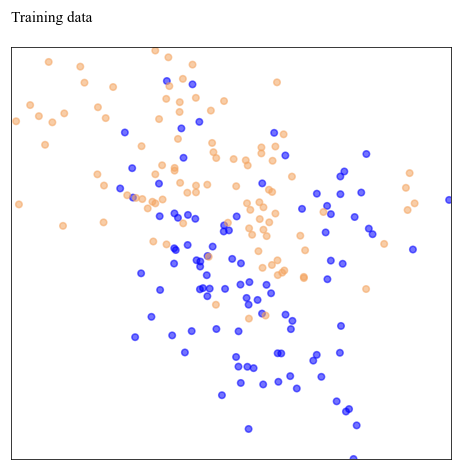

In [139]:
# prepares a plot with a title and circles representing training data
def plot_train_data(title):
    fig, ax = plt.subplots(figsize=(4, 4), dpi=110)
    ax.set_aspect(1.3)
    ax.scatter(X_train[:, 0], X_train[:, 1], s=18, color=np.array([BLUE, ORANGE])[y_train], alpha=0.55)
    ax.tick_params(
        bottom=False, left=False, labelleft=False, labelbottom=False)
    ax.set_xlim(-2.6, 4.2)
    ax.set_ylim(-2.0, 2.9)
    fig.subplots_adjust(left=0, right=1, top=1, bottom=0)
    ax.text(-2.6, 3.2, title, color=BLACK, fontsize=10)
    for spine in ax.spines.values():
        spine.set_color(BLACK)
    return fig, ax


# test it
_, _ = plot_train_data('Training data')

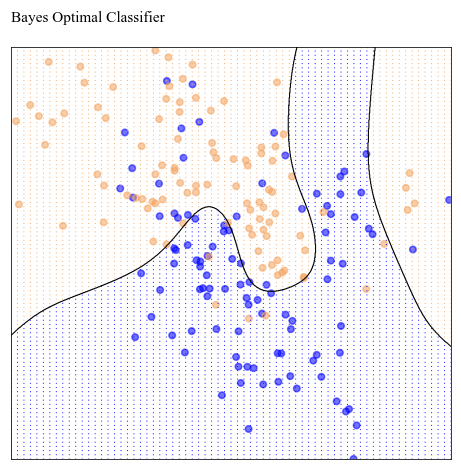

In [140]:
# given a model prediction function computes X points on n x n grid and the
# corresponding predicted classes
def fill_prediction_grid(n1, n2, predict):
    x1, x2 = np.linspace(-2.6, 4.2, n1), np.linspace(-2.0, 2.9, n2)
    X = np.transpose([np.tile(x1, n2), np.repeat(x2, n1)])
    y = predict(X)
    return X, y


# given a model prediction function computes X0 and X1 n x n meshgrids
# and the corresponing predicted classes meshgrid
def fill_prediction_meshgrid(predict):
    n1, n2 = 1000, 1000
    X, y = fill_prediction_grid(n1, n2, predict)
    return X[:, 0].reshape(n1, n2), X[:, 1].reshape(n1, n2), y.reshape(n1, n2)


# given a model prediction function plots train data, model decision
# bounary and background dots
def plot_model(predict, title):
    fig, ax = plot_train_data(title)
    # plot background dots
    X, y = fill_prediction_grid(69, 99, predict)
    ax.scatter(X[:, 0], X[:, 1], marker='.', lw=0, s=2,
               c=np.array([BLUE, ORANGE])[y])
    # plot the decision boundary
    X0, X1, Y = fill_prediction_meshgrid(predict)
    ax.contour(X0, X1, Y, [0.5], colors=BLACK, linewidths=[0.7])
    return fig, ax


# plot the optimal Bayes decision boundary
_, _ = plot_model(optimal_bayes_predict, 'Bayes Optimal Classifier')

In [141]:
# lets save Bayes meshgrids for optimal decision boundary plotting
X0_bayes, X1_bayes, Y_bayes = fill_prediction_meshgrid(optimal_bayes_predict)


# given a model prediction function plots performance statistics
def plot_model_stat(predict, title):
    fig, ax = plot_model(predict, title)
    ax.contour(X0_bayes, X1_bayes, Y_bayes, [0.5], colors='purple',
               linewidths=[0.5], linestyles='dashed')
    test_error_rate = 1 - accuracy_score(y_test, predict(X_test))
    train_error_rate = 1 - accuracy_score(y_train, predict(X_train))
    parms = {'color': BLACK, 'fontsize': 9,
             'bbox': {'facecolor': 'white', 'pad': 3, 'edgecolor': 'none'}}
    ax.text(-2.5, -1.41, f'Training Error: {train_error_rate:.3f}', **parms)
    ax.text(-2.5, -1.66, f'Test Error:       {test_error_rate:.3f}', **parms)
    ax.text(-2.5, -1.91, f'Bayes Error:    {bayes_error_rate:.3f}', **parms)
    return fig, ax

In [142]:
from sklearn.linear_model import LinearRegression

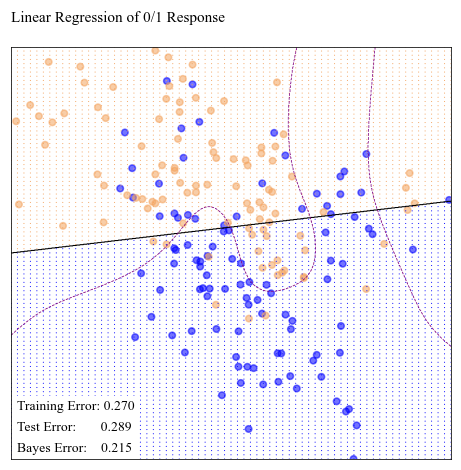

In [143]:
# Let’s look at an example of the linear model in a classification context.
linear_regression_model = LinearRegression().fit(X_train, y_train)


# The fitted values Y-hat are converted to a fitted class variable
# G-hat according to the rule G-hat = (ORANGE if Y-hat > 0.5, BLUE if
# Y-hat ≤ 0.5.
def linear_predict(X):
    return 1 * (linear_regression_model.predict(X) > 0.5)


# PAGE 13. The line is the decision boundary defined by x.T @ b = 0.5. The
#          orange shaded region denotes that part of input space classified as
#          ORANGE, while the blue region is classified as BLUE.
_, _ = plot_model_stat(linear_predict, 'Linear Regression of 0/1 Response')

In [144]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import GridSearchCV

In [145]:
# Run GridSearchCV to find the best n_neighbors parameter using the 10-folds
# CV. It finds 12, but if we selected the most parsimonious model within one
# standard error from the best model (one standard error rule), we will find 15.
k_neighbors_grid_search = GridSearchCV(
    KNeighborsClassifier(),
    {'n_neighbors': list(range(1, 100))},
    cv=10
).fit(X_train, y_train)
print(k_neighbors_grid_search.best_params_)

{'n_neighbors': 12}


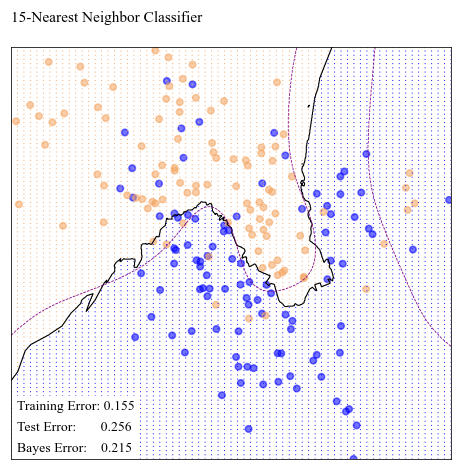

In [146]:
# Use 15-nearest-neighbor averaging of the binary coded response as
# the method of fitting. Thus Y-hat is the proportion of ORANGE’s in
# the neighborhood, and so assigning class ORANGE to G-hat if
# Y-hat>0.5 amounts to a majority vote in the neighborhood.
neighbors15_classifier = KNeighborsClassifier(
    n_neighbors=15
).fit(X_train, y_train)
_, _ = plot_model_stat(
    neighbors15_classifier.predict, '15-Nearest Neighbor Classifier')

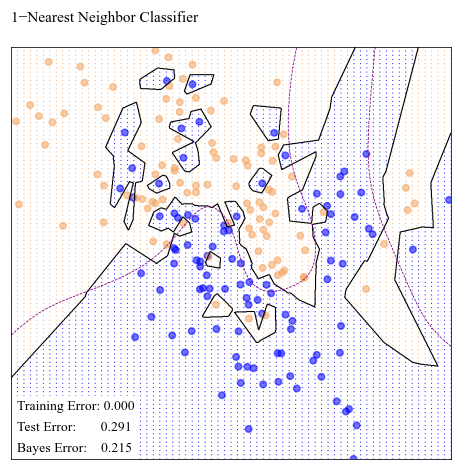

In [147]:
# The classes are coded as a binary variable (BLUE = 0,ORANGE = 1),
# and then predicted by 1-nearest-neighbor classification.
neighbors1_classifier = KNeighborsClassifier(
    n_neighbors=1
).fit(X_train, y_train)
_, _ = plot_model_stat(
    neighbors1_classifier.predict, '1−Nearest Neighbor Classifier')

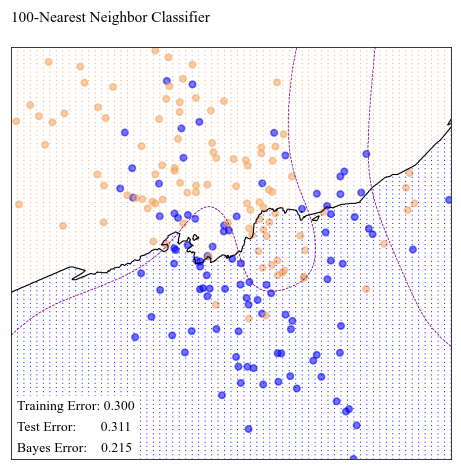

In [148]:
# Use 100-nearest-neighbor averaging of the binary coded response as
neighbors100_classifier = KNeighborsClassifier(
    n_neighbors=100
).fit(X_train, y_train)
_, _ = plot_model_stat(
    neighbors100_classifier.predict, '100-Nearest Neighbor Classifier')

In [149]:
n_neighbors_vals = list(range(1, 20)) + list(range(20, 101, 5))
k_neighbors_grid_search = GridSearchCV(
    KNeighborsClassifier(),
    {'n_neighbors': n_neighbors_vals},
    cv=10, scoring='accuracy',
    return_train_score=True, iid=True
).fit(X_train, y_train)
print(k_neighbors_grid_search.best_params_)

train_errors, test_errors = [], []
for k in n_neighbors_vals:
    clf = KNeighborsClassifier(n_neighbors=k).fit(X_train, y_train)
    train_errors.append(1 - clf.score(X_train, y_train))
    test_errors.append(1 - clf.score(X_test, y_test))

{'n_neighbors': 12}


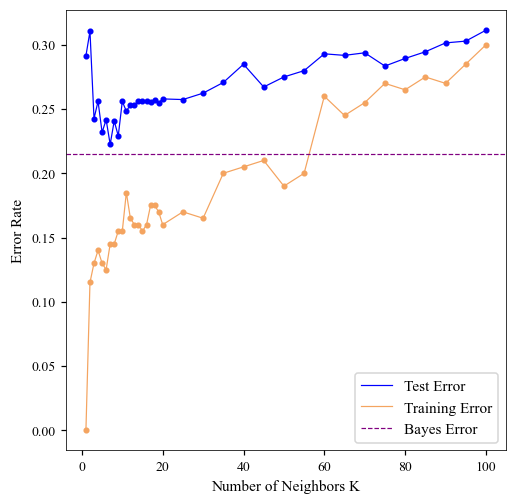

In [150]:
# k-nearest-neighbors on the two-class mixture data. The upper
# panel shows the misclassification errors as a function of
# neighborhood size. Standard error bars are included for 10-fold
# cross validation. The lower panel shows the decision boundary
# for 7-nearest-neighbors, which appears to be optimal for minimizing
# test error.

fig, ax = plt.subplots(figsize=(4, 4), dpi=110)
fig.subplots_adjust(left=0, right=1, top=1, bottom=0)
ax.scatter(n_neighbors_vals, test_errors, c=BLUE, s=9)
ax.plot(n_neighbors_vals, test_errors, c=BLUE, linewidth=0.8,
        label='Test Error')
ax.scatter(n_neighbors_vals, train_errors, c=ORANGE, s=9)
ax.plot(n_neighbors_vals, train_errors, c=ORANGE, linewidth=0.8,
        label='Training Error')
ax.axhline(y=bayes_error_rate, c=PURPLE, linewidth=0.8, linestyle='--',
           label='Bayes Error')
for i in ax.get_yticklabels() + ax.get_xticklabels():
    i.set_fontsize(9)
ax.set_xlabel('Number of Neighbors K', color=BLACK, fontsize=10)
ax.set_ylabel('Error Rate', color=BLACK, fontsize=10)
_ = ax.legend(loc='lower right', prop={'size': 10})

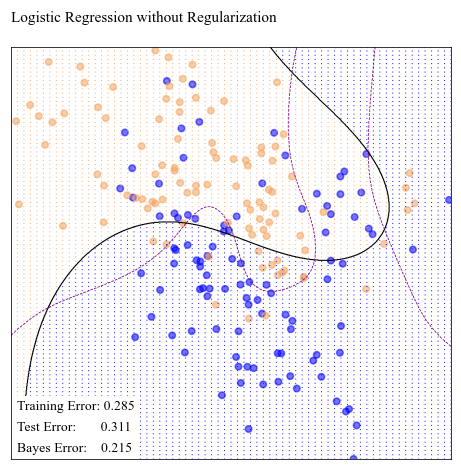

In [199]:
# Logistic Regression
from sklearn.linear_model import LogisticRegression, LogisticRegressionCV

x1 = X_train[:, 0]
x2 = X_train[:, 1]
column_list = [x1, x2, x1 ** 2, x1 * x2, x2 ** 2, x1 ** 3, x1 ** 2 * x2, x1 * x2 ** 2, x2 ** 3]
def make_table(columnList):
    pd_column_list = []
    for column in columnList:
        pd_column = pd.DataFrame(column)
        pd_column_list.append(pd_column)
    table = pd.concat(pd_column_list, axis=1)
    return table

training_datatable = make_table(column_list)
trainingX = training_datatable.values

noRegularizationClassifier = LogisticRegression(random_state=0).fit(trainingX, y_train)

def noRegularizationClassifier_predict(X):
    x1 = X[:, 0]
    x2 = X[:, 1]
    column_list = [x1, x2, x1 ** 2, x1 * x2, x2 ** 2, x1 ** 3, x1 ** 2 * x2, x1 * x2 ** 2, x2 ** 3]
    datatable = make_table(column_list)
    convertedX = datatable.values
    return noRegularizationClassifier.predict(convertedX)

_, _ = plot_model_stat(
    noRegularizationClassifier_predict, 'Logistic Regression without Regularization')

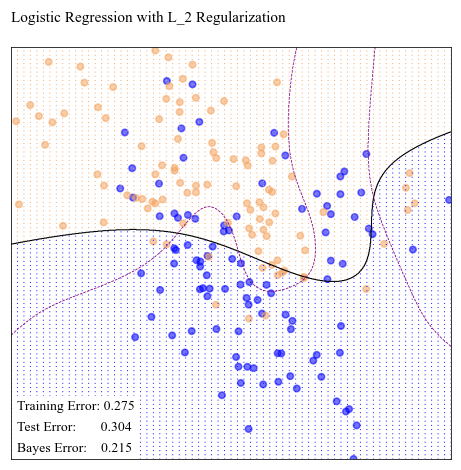

In [200]:
RegularizationClassifier = LogisticRegressionCV(cv=5, random_state=0).fit(trainingX, y_train)
def RegularizationClassifier_predict(X):
    x1 = X[:, 0]
    x2 = X[:, 1]
    column_list = [x1, x2, x1 ** 2, x1 * x2, x2 ** 2, x1 ** 3, x1 ** 2 * x2, x1 * x2 ** 2, x2 ** 3]
    datatable = make_table(column_list)
    convertedX = datatable.values
    return RegularizationClassifier.predict(convertedX)

_, _ = plot_model_stat(
    RegularizationClassifier_predict, 'Logistic Regression with L_2 Regularization')
